# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

1. Based on the data set, what features drive the price to be higher for a used car.  
2. Can we define set of rules which would help us predict the price we can sell the car?
3. Are there features that should be avoided and contributes negatively to the price?

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

1. List the available values per column  
2. Identify records with NaN values  
3. How many columns are not numeric? How many distinct values are there in the non-numeric columns? Can we use one-hot encoding?  
4. What is the quality of the data? Are there are any outliers or incomplete data?  

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [580]:
## Required imports
import datetime
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots

from pandas.core.nanops import nanmean as pd_nanmean
from statsmodels.tsa.seasonal import _extrapolate_trend
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings 

from scipy import stats
from category_encoders import BinaryEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
from sklearn.inspection import permutation_importance

filterwarnings('ignore')

In [581]:
# load data
cars = pd.read_csv('data/vehicles.csv')

In [582]:
# set index
cars = cars.set_index('id')

In [583]:
# show columns
cars.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [584]:
# check head
cars.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
id,,,,,,,,,,,,,,,,,
7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


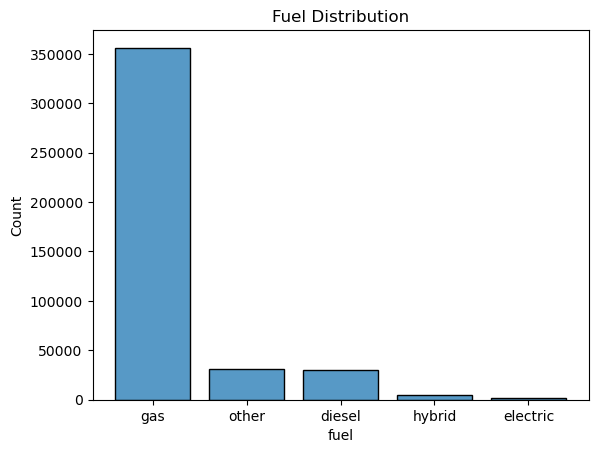

In [585]:
# Plot distributions
sns.histplot(data=cars, x='fuel', shrink=0.8, discrete=True)
plt.title('Fuel Distribution')
plt.show()


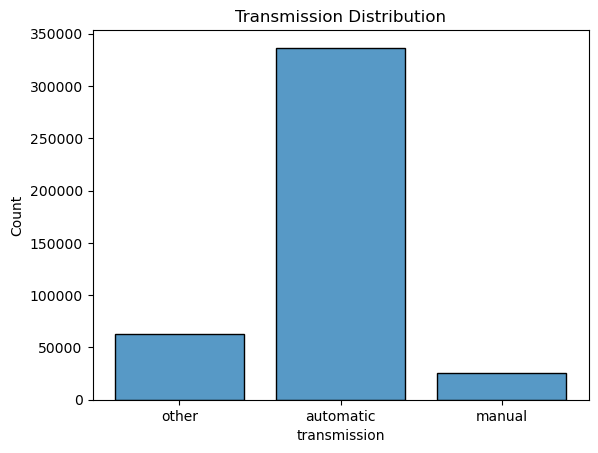

In [586]:
sns.histplot(data=cars, x='transmission', shrink=0.8, discrete=True)
plt.title('Transmission Distribution')
plt.show()


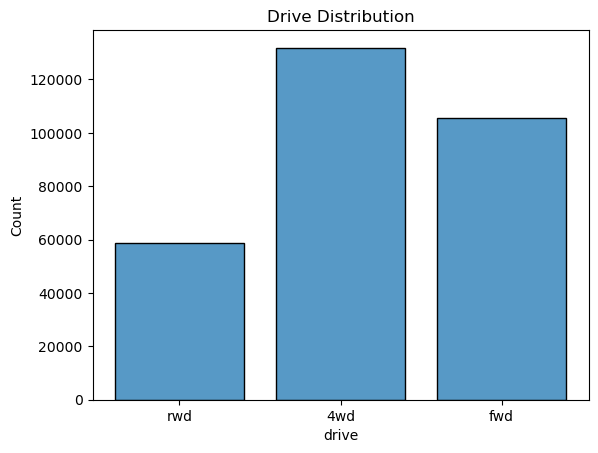

In [587]:
sns.histplot(data=cars, x='drive', shrink=0.8, discrete=True)
plt.title('Drive Distribution')
plt.show()

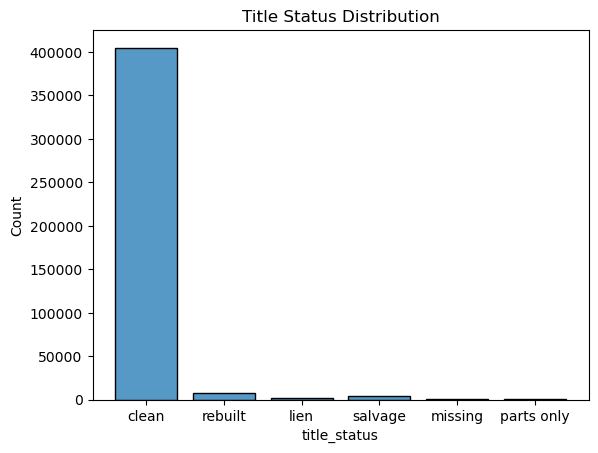

In [588]:
sns.histplot(data=cars, x='title_status', shrink=0.8, discrete=True)
plt.title('Title Status Distribution')
plt.show()

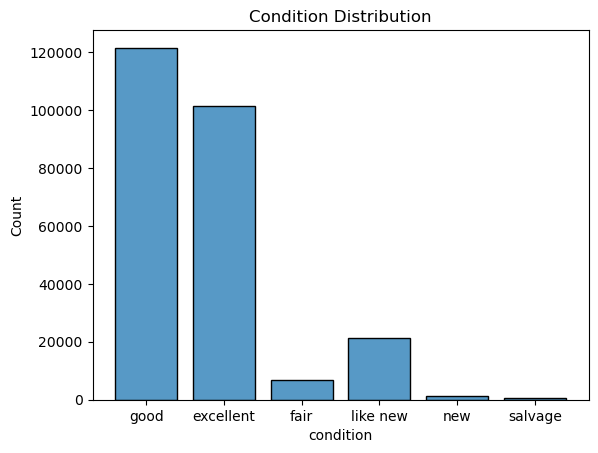

In [589]:
sns.histplot(data=cars, x='condition', shrink=0.8, discrete=True)
plt.title('Condition Distribution')
plt.show()

In [590]:
# based on the histograms, we will filter the data set
# remove rows with NaN values
cars = cars.dropna()
# remove duplicate rows with the same VIN
cars = cars.drop_duplicates(subset='VIN')
# remove rows were price = 0
cars = cars[cars['price'] > 0]
# remove rows where fuel = other
cars = cars[cars['fuel'] != 'other']
# drop VIN column
cars = cars.drop('VIN', axis=1)
# drop region column
cars = cars.drop('region', axis=1)
# only keep rows where year > 2012
cars = cars[cars['year'] > 2012]
# only keep rows where price > 1000
cars = cars[cars['price'] > 1000]
# convert cylinders to int by removing the text after the space and if value is other, set to 0
cars['cylinders'] = cars['cylinders'].apply(lambda x: int(x.split()[0]) if x != 'other' else 0)
# convert odometer to int
cars['odometer'] = cars['odometer'].apply(lambda x: int(x))
# convert price to int
cars['price'] = cars['price'].apply(lambda x: int(x))
# keep gas only
cars = cars[cars['fuel'] == 'gas']
# keep automatic only
cars = cars[cars['transmission'] == 'automatic']
# remove cars with 0 cylinders
cars = cars[cars['cylinders'] > 0]
# remove cars with 0 odometer
cars = cars[cars['odometer'] > 0]
# keep clean title only
cars = cars[cars['title_status'] == 'clean']
# condition in good, excellent, like new
cars = cars[(cars['condition'] == 'good') | (cars['condition'] == 'excellent') | (cars['condition'] == 'like new')]
# since there's only one value in these columns, we will remove them
cars = cars.drop('fuel', axis=1)
cars = cars.drop('transmission', axis=1)
cars = cars.drop('model', axis=1)

In [591]:
# check value_counts for non numeric columns
non_numeric_columns = cars.select_dtypes(exclude=['int64', 'float64']).columns
for column in non_numeric_columns:
    print(cars[column].value_counts())


manufacturer
ford             1500
chevrolet        1062
toyota            506
nissan            506
honda             351
jeep              333
ram               315
gmc               311
dodge             259
hyundai           253
kia               235
subaru            222
bmw               215
volkswagen        190
mercedes-benz     159
chrysler          132
audi              127
mazda             106
buick              99
cadillac           94
lexus              84
lincoln            60
infiniti           54
acura              50
volvo              49
rover              41
mitsubishi         40
porsche            27
mini               26
fiat               12
jaguar              6
alfa-romeo          3
Name: count, dtype: int64
condition
excellent    4435
good         1651
like new     1341
Name: count, dtype: int64
title_status
clean    7427
Name: count, dtype: int64
drive
4wd    3494
fwd    2804
rwd    1129
Name: count, dtype: int64
size
full-size      4072
mid-size       2372
c

In [592]:
# check correlation of numeric columns in cars
# use numeric columns only
cars_numeric = cars.select_dtypes(include=['int64', 'float64'])
# check correlation
cars_numeric.corr()


,price,year,cylinders,odometer
price,1.000000,0.506890,0.511496,-0.430895
year,0.506890,1.000000,-0.028334,-0.587433
cylinders,0.511496,-0.028334,1.000000,0.145128
odometer,-0.430895,-0.587433,0.145128,1.000000


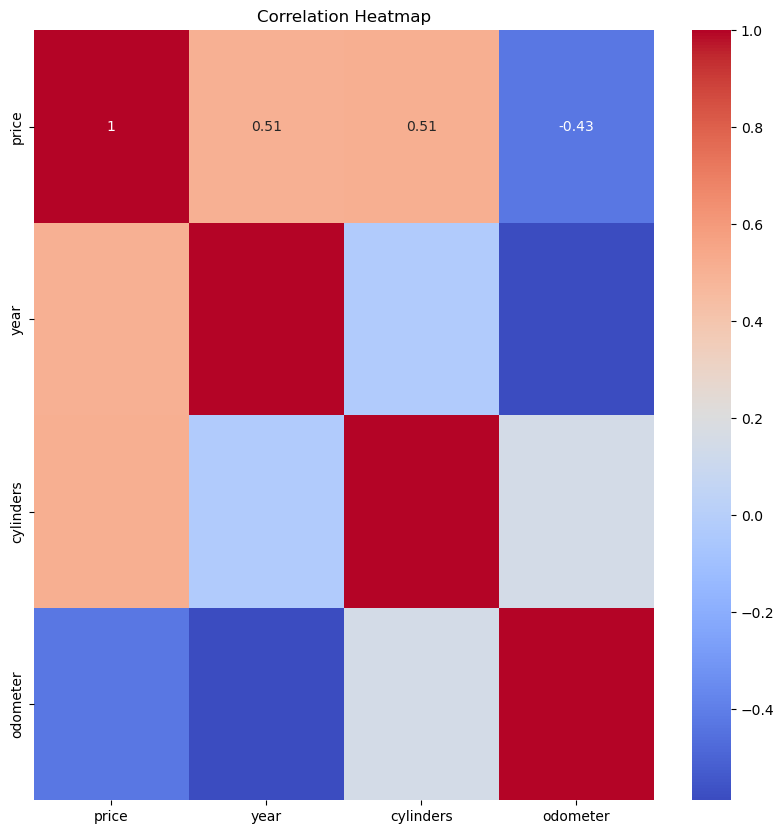

In [593]:
#visualize correlation of cars_numeric
plt.figure(figsize=(10, 10))
sns.heatmap(cars_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Both cylinders and year have strong positive correlation.  Odometer on the other hand has a negative correlation 

<Figure size 800x640 with 0 Axes>

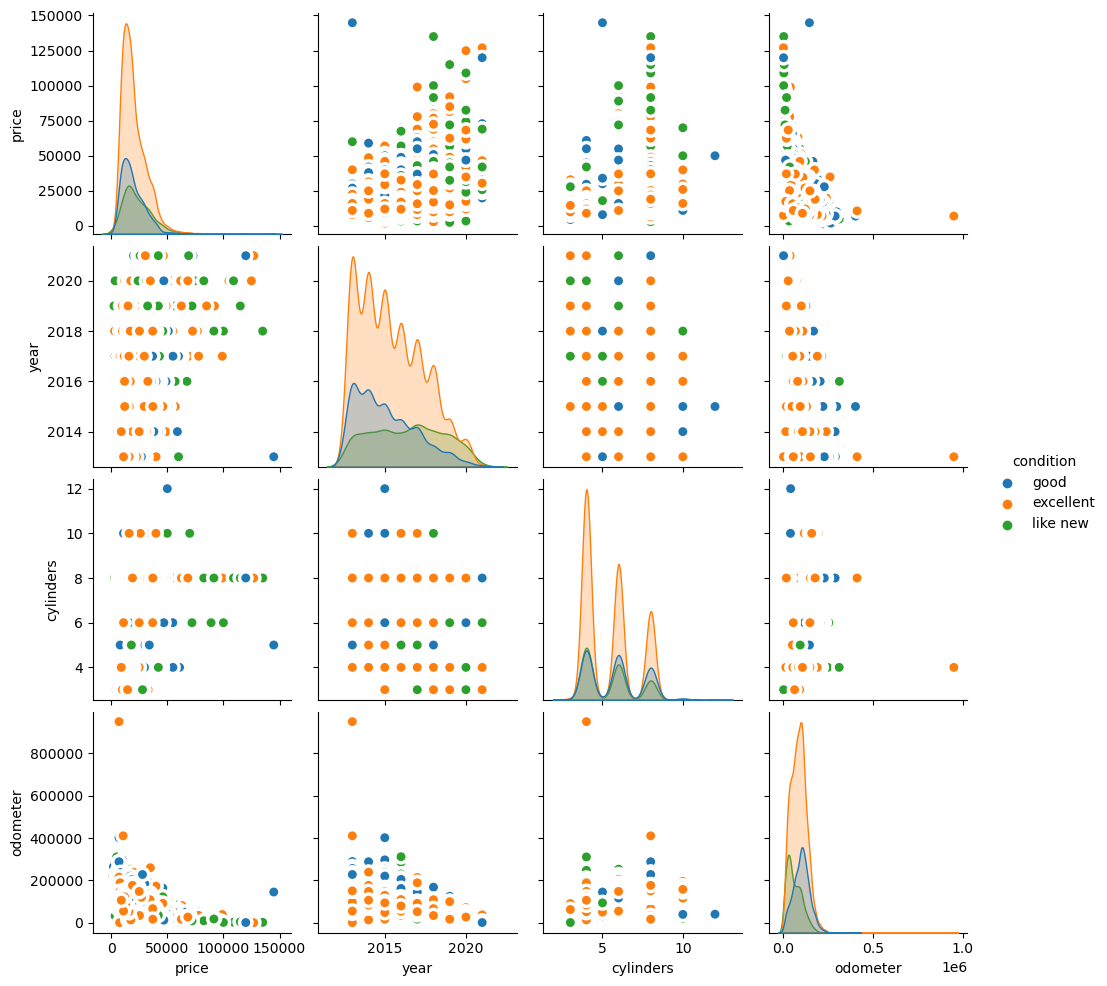

In [594]:
# Pairwise Plot
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(cars, kind="scatter", hue="condition", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

In [595]:
cars

,price,year,manufacturer,condition,cylinders,odometer,title_status,drive,size,type,paint_color,state
id,,,,,,,,,,,,
7314956487,72900,2021.0,chevrolet,good,8,19129,clean,4wd,full-size,SUV,grey,al
7314956410,28900,2017.0,audi,good,6,94601,clean,4wd,full-size,SUV,white,al
7314956329,17000,2019.0,chevrolet,good,4,14898,clean,4wd,full-size,SUV,grey,al
7314584193,9500,2014.0,toyota,good,4,136128,clean,fwd,mid-size,hatchback,white,al
7314583885,12900,2014.0,nissan,good,4,120211,clean,fwd,full-size,SUV,red,al
...,...,...,...,...,...,...,...,...,...,...,...,...
7311438784,10999,2013.0,dodge,excellent,6,54738,clean,fwd,mid-size,sedan,black,wy
7307387666,11999,2014.0,hyundai,excellent,4,122216,clean,4wd,mid-size,SUV,silver,wy
7306727130,18999,2014.0,ford,excellent,8,176261,clean,4wd,full-size,pickup,black,wy


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [596]:
# Create X and y dataframes and split data into training and test sets
X = cars.drop('price', axis=1)
y = cars['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [597]:
# Define numeric feature columns
numeric_features = ['year', 'cylinders', 'odometer']

# columns for one hot encoding
onehot_features = ['condition', 'title_status', 'drive', 'size', 'type', 'paint_color', 'manufacturer','state']

# Define numeric transformer
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define the onehot transformer
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop="if_binary"))
])

# Create a ColumnTransformer to apply numeric and non-numeric transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('encoder', onehot_transformer, onehot_features)
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)



Model using SFS

In [598]:
selector_pipe = ''
selector_pipe = Pipeline([('preprocessor', preprocessor),
                          ('selector', SequentialFeatureSelector(LinearRegression())),
                         ('model', LinearRegression())])

In [599]:
param_dict = {}
selector_grid = ''
selector_train_mse = ''
selector_test_mse = ''

# set param_dict values from 2 to 124
param_dict = {'selector__n_features_to_select': np.arange(2, 10)}
selector_grid = GridSearchCV(selector_pipe, param_grid=param_dict)
selector_grid.fit(X_train, y_train)
train_preds = selector_grid.predict(X_train)
test_preds = selector_grid.predict(X_test)
selector_train_mse = mean_squared_error(y_train, train_preds)
selector_test_mse = mean_squared_error(y_test, test_preds)

print(f'Train MSE: {selector_train_mse}')
print(f'Test MSE: {selector_test_mse}')

Train MSE: 47873115.515239246
Test MSE: 47169898.15803452


Model using Ridge

In [600]:
ridge_pipe = ''
ridge_pipe = Pipeline([('preprocessor', preprocessor),
                      ('ridge', Ridge())])

In [601]:
ridge_param_dict = ''
ridge_grid = ''
ridge_train_mse = ''
ridge_test_mse = ''


ridge_param_dict = {'ridge__alpha': np.logspace(0, 10, 50)}

ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict)
ridge_grid.fit(X_train, y_train)
ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)



print(f'Train MSE: {ridge_train_mse}')
print(f'Test MSE: {ridge_test_mse}')


Train MSE: 41671700.373223394
Test MSE: 41627723.949779995


Model using Lasso

In [602]:
lasso_pipe = ''

lasso_pipe = Pipeline([('preprocessor', preprocessor),
                      ('lasso', Lasso(random_state = 42))])


In [603]:
lasso_train_preds = ''
lasso_test_preds = ''
lasso_train_mse = ''
lasso_test_mse = ''

lasso_pipe.fit(X_train, y_train)
lasso_train_preds = lasso_pipe.predict(X_train)
lasso_test_preds = lasso_pipe.predict(X_test)
lasso_train_mse = mean_squared_error(y_train, lasso_train_preds)
lasso_test_mse = mean_squared_error(y_test, lasso_test_preds)



print(f'Train MSE: {lasso_train_mse}')
print(f'Test MSE: {lasso_test_mse}')

Train MSE: 41600169.85864303
Test MSE: 41290033.24595351


Lowest test MSE is with Lasso so we will be using this model to get the features with highest coef.

In [604]:
feature_names = lasso_pipe.named_steps['preprocessor'].get_feature_names_out()
coefs = pd.DataFrame(
    lasso_pipe.named_steps['lasso'].coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs.sort_values(by="Coefficients", key=abs, ascending=False).head(20)

,Coefficients
manufacturer_porsche,20839.512965
manufacturer_rover,8034.051796
type_offroad,5546.553135
manufacturer_volvo,5504.079913
manufacturer_mercedes-benz,4870.392450
manufacturer_lexus,4611.925287
manufacturer_mitsubishi,-4557.460485
cylinders,4477.957373
manufacturer_jaguar,4474.375677
year,3863.324403


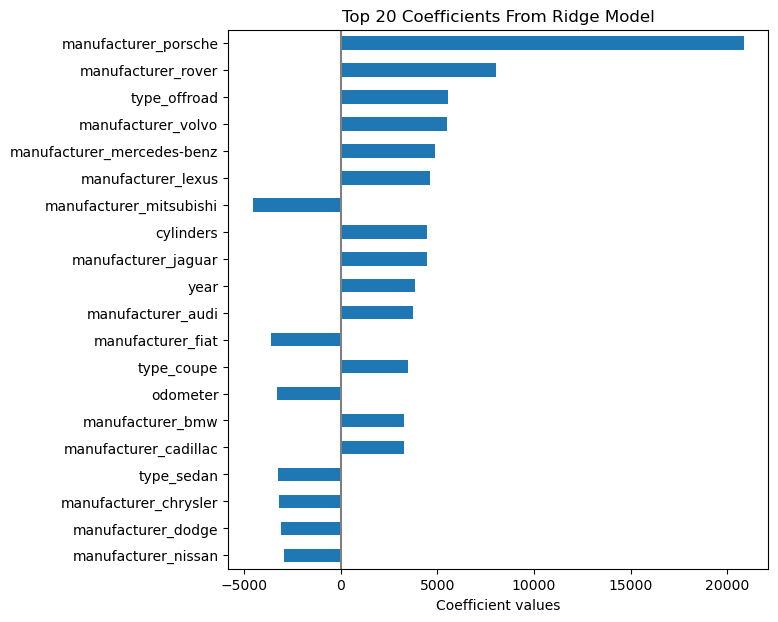

In [605]:
coefs.sort_values(by="Coefficients", key=abs, ascending=False).head(20).plot.barh(figsize=(9, 7))
plt.title("Top 20 Coefficients From Ridge Model")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient values")
plt.subplots_adjust(left=0.3)
plt.gca().invert_yaxis()
plt.gca().get_legend().remove()


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Top Manufacturers (higher price)
1. Porsche
2. Rover
3. Volvo
4. Mercedes Benz
5. Lexus
6. Jaguar
7. Audi
8. BMW
9. Cadillac

Bottom Manufacturers (lower price)
1. Mitsubushi
2. Fiat
3. Chrysler
4. Dodge
5. Nissan

Features that contributes to a higher price
1. Cylinders => higher the better
2. Year => higher the better
3. Type = coupe


Features of lower priced vehicles
1. Odometer = higher odometer reading lowers the price
2. Type = sedan


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Based on our analysis of the data and identifying the best model, here are the features of cars that can be sold for a higher price:

1. Manufacturer = Porsche, Rover, Volvo, Mercedes Benz, Lexus, Jaguar, Audi, BMW, Cadillac
2. Cylinders >= 6
3. Year >= 2015
4. Type = coupe
5. Odometer < 50k